[Cranberry Sauce Riddler](https://fivethirtyeight.com/features/can-you-pass-the-cranberry-sauce/)

Prompt:
> To celebrate Thanksgiving, you and 19 of your family members are seated at a circular table (socially distanced, of course). Everyone at the table would like a helping of cranberry sauce, 
> which happens to be in front of you at the moment.
>
> Instead of passing the sauce around in a circle, you pass it randomly to the person seated directly to your left or to your right. They then do the same, passing it randomly either to the person to their left or right. This 
> continues until everyone has, at some point, received the cranberry sauce.
>
> Of the 20 people in the circle, who has the greatest chance of being the last to receive the cranberry sauce?

In [1]:
# math
import numpy as np
from math import floor, ceil
import networkx as nx
from collections import OrderedDict

# data manipulation
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from networkx.drawing.nx_agraph import graphviz_layout

## Auxilliary Markov Process

The functions in this section are used to provide terminal properties for a drunkard's walk on a finite interval. We use this in the main cranberry passing Markov process to specify the probability that the next guest to receive the cranberry sauce will be next to the person holding the cranberry sauce, or will be the person sitting next to the furthest person who has already been served. In addition, we also calculate the number of passes that will be made in each case.

In [2]:
def drunkard_walk_transition_matrix(n_interval):
    # P is the transition matrix
    P = np.zeros((n_interval + 2, n_interval + 2))
    P[0, 0] = 1
    P[n_interval+1, n_interval+1] = 1
    for i in range(1, n_interval + 1):
        P[i, i-1] = 0.5
        P[i, i+1] = 0.5
    
    return P

In [3]:
def drunkard_walk_exit_distro(n_interval):
    '''
    Compute the probability that a random walk exits an interval of length 
    n from the left or right, conditioned on beginning at the left-most end of the 
    interval.
    
    Input: 
    n_interal: length of interval
    max_iter : maximum number of iterations to use
    
    Returns: 
    (p_near, p_far): where p_near = probability of left-exit, and
      p_far = probability of right-exit.
    '''
    
    if n_interval == 1:
        return 0.5, 0.5
    
    # P is the drunkard's walk transition matrix
    P = drunkard_walk_transition_matrix(n_interval)
        
    # Put P in canonical form
    n_transient = 2
    idxs = list(range(1, n_interval + 1)) + [0, n_interval + 1]
    P = P[idxs, :]
    P = P[:, idxs]
    
    # Transient submatrix Q and transition to absorbing matrix R
    n_absorbing = 2
    Q = P[:-n_absorbing, :-n_absorbing]
    R = P[:-n_absorbing, -n_absorbing:]
    N_inv = np.eye(n_interval) - Q
    
    # Solve for B, whose rows represent absorption probabilities
    # starting from a given transient state, and columns represent
    # probability of absorption into a specific absorbing state.
    # see e.g. 
    #    https://en.wikipedia.org/wiki/Absorbing_Markov_chain#Absorbing_probabilities
    B = np.linalg.solve(N_inv, R)
    
    # We're only interested in absorption from the first state into
    # each of the absorbing states.    
    p_left = B[0, 0]
    p_right = B[0, 1]
    
    return p_left, p_right    

In [4]:
def drunkard_walk_avg_exit_time_each_side(n_interval):
    
    P = drunkard_walk_transition_matrix(n_interval)
    
    # re-order to put P in "standard form" with absorbing states at 
    # the end
    idxs = list(range(1, n_interval + 1)) + [0, n_interval + 1]
    P = P[idxs, :]
    P = P[:, idxs]
    
    # Important matrices
    Q = P.copy()[:-2, :-2]
    R = P.copy()[:n_interval, -2:]
    #N = np.linalg.inv(np.eye(n_interval) - Q)
    N_inv = np.eye(n_interval) - Q
        
    # Compute B = N*R = (I - Q)^-1 * R
    B = np.linalg.solve(np.eye(n_interval) - Q, R)    
    
    # compute quantities from B for left/right absorbing states
    b_left = B[:, 0]
    b_right = B[:, 1]
    D_left = np.diag(b_left)
    D_right = np.diag(b_right)
    
    # Use theorem 1 from:
    #   https://doi.org/10.1016/j.spl.2019.04.001
    # which is available for free download on ResearchGate:
    #   https://www.researchgate.net/publication/332384778_Applications_of_the_fundamental_matrix_to_mean_absorption_and_conditional_mean_absorption_problems
    # Using this theorem, we get alpha, the mean number of steps from 
    # any starting state as follows:
    #  alpha_left = D_left^{-1} * N * D_left * xi
    #  alpha_right = D_right^{-1} * N * D_right * xi
    # where xi is a vector of ones. we're only interested in the first entry of
    # alpha_left and alpha_right.
    xi = np.ones(n_interval)
    
    # compute mu_left. 
    xi_left = np.dot(D_left, xi)
    alpha_left = np.linalg.solve(N_inv, xi_left)
    alpha_left = np.linalg.solve(D_left, alpha_left)
    mu_left = alpha_left[0]
    
    # compute mu_right. 
    xi_right = np.dot(D_right, xi)
    alpha_right = np.linalg.solve(N_inv, xi_right)
    alpha_right = np.linalg.solve(D_right, alpha_right)
    mu_right = alpha_right[0]    
    
    return mu_left, mu_right

In [5]:
def drunkard_walk_avg_exit_time(n_interval):
    p_left, p_right = drunkard_walk_exit_distro(n_interval)
    mu_left, mu_right = drunkard_walk_avg_exit_time_each_side(n_interval)
    
    return p_left * mu_left + p_right * mu_right

## Main Cranberry Passing Markov Process

In this process, we are only interested in tracking the "boundary" of the guests who have already been served. States of this system are either 
  1. a tuple of the form `(most_recently_served, interval_served, n_served)` 
  2. an integer representing the last guest to be served.

Transition probabilities in this Markov process are governed by a drunkard's walk on `interval_served` (i.e. the auxiliary walk indicated above), and indicate whether the nearest unserved guest receives the sauce next, or whether the furthest unserved guest is served next.

Each step in this process represents one new guest being served, and the number of steps in this process does *not* indicate the number of cranberry sauce passes. To compute the average number of passes requies a bit of work using the number of transitions in the drunkard's walk.

In [6]:
def table_dist(i, j, n_guests):
    '''
    Compute number of spaces between position i and j around a table 
    with n_guests
    
    Input: 
    i, j: position indices for two guests to be compared
    n_guests: the number of guests at table
           
    '''    
    diff = abs(i - j)
    
    if diff <= floor(n_guests / 2):
        return diff
    else:
        return n_guests - diff

In [7]:
def receiver_states(state, n_guests):
    '''
    Generate the states which can be reached from the current state.
    
    Input: 
    state: either a tuple of the form (current_pos, interval, n_served)
      or an integer representing a terminal state
    n_guests: the number of guests at the table
    
    Return: 
    receptive_states: either a list of the possible transition states,
      if state is not terminal, and None if state is terminal (!!)    
    '''
    
    if state == (0, (0, 0), 1):
        receptive_states = [(n_guests-1, (n_guests-1, 0), 2), (1, (0, 1), 2)]
    
    elif type(state) == tuple:
        i, j = state[1]
        n_served = state[2]
        
        if n_served == n_guests - 1:
            if [i, j] == [0, n_guests - 2]:
                receptive_states = [n_guests - 1]
            elif [i, j] == [n_guests - 2, 0]:
                receptive_states = [1]            
            else:
                receptive_states = [(i + j) // 2]
        
        else:
            i_left  = (i - 1) % n_guests
            j_right = (j + 1) % n_guests
            receptive_states = [(i_left,  (i_left,  j), n_served + 1), 
                                 (j_right, (i, j_right), n_served + 1)]
    else:
        receptive_states = None   
        
    return receptive_states

In [8]:
def generate_states(n_guests):
    '''
    Generate the transition states for Cranberry passing in sorted order.
    
    Input: 
    n_guests: number of guests around the table
    
    Return: 
    transition_states: either a list of the possible transition states, 
      or None if the state is terminal (!)
    '''
    
    starting_state = (0, (0,0), 1)
    states = [starting_state]
    new_states = list(OrderedDict.fromkeys(states))
    
    for n_served in range(1, n_guests):
        new_states = [s_new for s in new_states for s_new in 
                      receiver_states(s, n_guests)]
        new_states = list(OrderedDict.fromkeys(new_states))
        states.extend(new_states)
        
    # dictionary mapping state to its index
    n_states = len(states)    
    state_to_idx = dict(zip(states, range(n_states)))    
    
    return states, state_to_idx, n_states   

In [9]:
def cranberry_passing_transition_matrix(n_guests):
    '''
    Construct the cranberry passing transition matrix.
    
    Input: 
    n_guests: the number of guests at the table
    
    Returns: 
    (p_near, p_far) where p_near = probability of left-exit, and
      p_far = probability of right-exit.
    '''
    
    states, state_to_idx, n_states = generate_states(n_guests)

    # list of tuples, containing (p_near, p_far) interval exit probabilities
    exit_probs = [None] + [drunkard_walk_exit_distro(i) for i in range(1, n_guests)]
    
    # compute transition matrix
    P = np.zeros((n_states, n_states))
    
    for state in states:
        # non-absorbing states are encoded as tuples
        if type(state) == tuple:
            idx_state = state_to_idx[state]
            n_served = state[2]
            receivers = receiver_states(state, n_guests)
            
            # if only one receiver, then transition is to a final state
            if len(receivers) == 1:
                state_child = receivers[0]
                idx_child = state_to_idx[state_child]
                P[idx_state, idx_child] = 1
            
            # non-terminal states
            if len(receivers) == 2:
                state_left, state_right = receivers
                
                # position on table for each state
                pos_state = state[0]
                pos_left = state_left[0]
                pos_right = state_right[0]                
                
                # determine if left or right is nearest position to the start state
                if table_dist(pos_left, pos_state, n_guests) < table_dist(pos_right, pos_state, n_guests):
                    state_near, state_far = state_left, state_right
                else:
                    state_near, state_far = state_right, state_left 
                
                # assign probability that we exit through either the near or far state
                idx_near, idx_far = state_to_idx[state_near], state_to_idx[state_far]
                p_near, p_far = exit_probs[n_served]
                P[idx_state, idx_near] = p_near
                P[idx_state, idx_far] = p_far
        
        # absorbing state
        else:
            idx_state = state_to_idx[state]            
            P[idx_state, idx_state] = 1

    return P    

In [10]:
def receive_cranberries_last_probabilities(n_guests):
    '''
    Calculate the probability that each guest receives the cranberry sauce last, 
    given that the cranberry sauce starts at position 0.
    
    Input: 
    n_guests: the number of guests at the table
    max_iter: maximum number of iterations when estimating the terminal distribution
    tol: tolerance for convergence
    
    Returns: 
    pi_limit: exit distribution for terminal states (and 0)
    '''
    
    # determine all the possible states
    states, state_to_idx, n_states = list(generate_states(n_guests))        
           
    # iterate to compute the limiting distribution beginning from 
    # starting position (0, (0,0), 0)
    pi_old = np.zeros(n_states)
    pi_new = np.copy(pi_old)
    start_position = (0, (0, 0), 1)
    start_idx = state_to_idx[start_position]
    pi_new[start_idx] = 1
    
    # compute transition matrix
    # Note: P is in canonical form by construction    
    P = cranberry_passing_transition_matrix(n_guests)
    
    # compute useful quantities
    n_absorbing = n_guests - 1
    n_transient = n_states - n_absorbing
    Q = P[:n_transient, :n_transient]
    R = P[:n_transient, -n_absorbing:]
    N_inv = np.eye(n_transient) - Q
    
    # solve for B, the probability of ending up in a 
    # given absorbing state (col) starting from a given
    # transient state (rows)
    B = np.linalg.solve(N_inv, R)
    
    # only interested in root --> terminal state 
    # probabilities. root, i.e. (0, (0, 0), 0) is
    # simply the first row of B
    pi_limit = B[0, :]
    
    # finally, add a zero for the root node's probability
    # of being last
    pi_limit = np.array([0] + list(pi_limit))
    
    # create return dataframe
    df_pi_limit = pd.DataFrame(zip(list(range(0, n_guests)), pi_limit), 
                               columns = ['guest_number', 'probability_last'])
    df_pi_limit = df_pi_limit[df_pi_limit['guest_number'] > 0]
    df_pi_limit.set_index('guest_number', inplace=True)    
    
    return df_pi_limit

In [11]:
def mean_passes(n_guests):
    '''
    Calculate the mean number of passes that required for all guests to receive the 
    the cranberry sauce, given that the sauce starts at position 0.
    
    Input: 
    n_guests: the number of guests at the table
    
    Returns: 
    df_mean_passes: dataframe containing mean number of passes until everyone has been served
    '''
    
    # prep work: comute mean number of passes to exit an 
    # interval of length k from near or far edge, beginning
    # on the near edge
    mean_passes_near = np.zeros(n_guests + 1)
    mean_passes_far = np.zeros(n_guests + 1)
    for k in range(1, n_guests + 1):
        mean_passes_near[k], mean_passes_far[k] = drunkard_walk_avg_exit_time_each_side(k)
        
    # for the final transition, we collapse to states into one, so compute the
    # mean without conditioning on being near or far
    mean_to_terminal = drunkard_walk_avg_exit_time(n_guests - 1)
    
    # determine all the possible cranbery passing states 
    states, state_to_idx, n_states = list(generate_states(n_guests))        
           
    # compute transition matrix for cranberry passing
    P = cranberry_passing_transition_matrix(n_guests)
        
    # compute adjacency graph. first we remove self-loops to form DAG
    P_adj = P.copy()
    n_terminal = n_guests - 1
    P_adj[-n_terminal:, -n_terminal:] = 0 * P_adj[-n_terminal:, -n_terminal:]
    G = nx.from_numpy_matrix(P_adj, create_using=nx.DiGraph)
    G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), states)))
    
    # terminal nodes are the singleton nodes in G
    terminal_nodes = [k for k in range(1, n_guests)]
    
    # dict to hold
    mean_steps_this_node = np.zeros(n_guests)
    
    # root of graph
    state_root = (0, (0,0), 1)
    
    # iterate over terminal states
    for state_end in terminal_nodes:
        
        # iterate over all paths from root state to terminal state
        paths_from_root_to_end = nx.all_simple_paths(G, state_root, state_end)
        prob_of_path = []
        mean_steps_path = []

        for path in paths_from_root_to_end:
            prob_this_path = 1
            mean_steps_this_path = 0
            
            state_prev = path[0]
            idx_prev = state_to_idx[state_prev]
            pos_prev = state_prev[0]
            
            for state_curr in path[1:]:
                idx_curr = state_to_idx[state_curr]
                
                # Two cases:
                # 1) not end ==> not terminal ==> tuple
                # 2) end ==> terminal ==> state is integer of position
                if state_curr != state_end:
                    pos_curr = state_curr[0]
                else:
                    pos_curr = state_curr
                
                # the interval of served people has length:
                n_already_served = state_prev[2]
                
                # determine the average number of moves before a new person
                # is served
                if state_curr in terminal_nodes:
                    mean_moves = mean_to_terminal
                elif table_dist(pos_curr, pos_prev, n_guests) > 1:
                    mean_moves = mean_passes_far[n_already_served]
                else:
                    mean_moves = mean_passes_near[n_already_served]
                
                # propagate path probability and number of steps
                prob_this_path *= P[idx_prev, idx_curr]
                mean_steps_this_path += mean_moves
                
                # update for next step of iteration
                state_prev = state_curr
                idx_prev = idx_curr
                pos_prev = pos_curr
            
            # store data for this path
            prob_of_path.append(prob_this_path)
            mean_steps_path.append(mean_steps_this_path)
        
        # aggregate data across paths from root to this terminal node to
        # compute the mean number of passes for this terminal node
        prob_of_path = np.array(prob_of_path)
        mean_steps_path = np.array(mean_steps_path)
        mean_steps_this_node[state_end] = np.sum(np.multiply(prob_of_path, mean_steps_path) / np.sum(prob_of_path))
    
    # create return dataframe
    df_mean_passes = pd.DataFrame(zip(list(range(0, n_guests)), mean_steps_this_node), 
                                 columns = ['guest_number', 'mean_number_passes'])
    df_mean_passes = df_mean_passes[df_mean_passes['guest_number'] > 0]
    df_mean_passes.set_index('guest_number', inplace=True)
    
    return df_mean_passes

## Six Guests

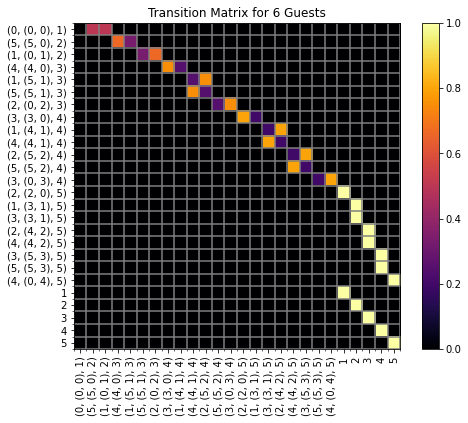

In [12]:
n_guests = 6
states, state_to_idx, n_states = generate_states(n_guests)
state_labels = [str(s) for s in states]
P = cranberry_passing_transition_matrix(n_guests)

# construct the plot
fig, ax = plt.subplots(figsize = (8,6), facecolor = 'w')
cm = ax.imshow(P,  cmap='inferno')

# major ticks with labels
ax.set_yticks(np.arange(n_states))
ax.set_xticks(np.arange(n_states))
ax.set_xticklabels(state_labels, rotation=90)
ax.set_yticklabels(state_labels, rotation=0)

# minor ticks + grid
ax.set_xticks(np.arange(-.5, n_states, 1), minor=True)
ax.set_yticks(np.arange(-.5, n_states, 1), minor=True)        
ax.grid(which='minor', color='grey', linestyle='-', linewidth=1.5)
ax.set_title("Transition Matrix for {} Guests".format(n_guests))
fig.colorbar(cm);

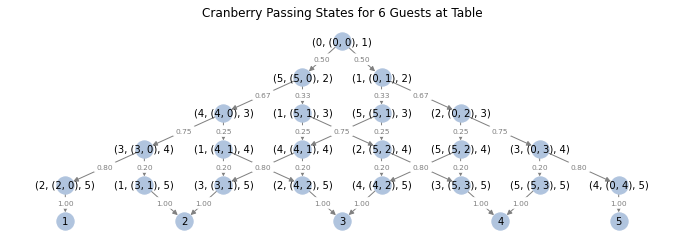

In [13]:
# adjacency matrix is the matrix whose i,j is 1 if there is a transition from i to j
# and 0 otherwise
P_adjacency = P > 0

# construct the adjacency graph (for this problem, it's a directed tree) 
# from the adjacency matrix
G = nx.from_numpy_matrix(P_adjacency, create_using=nx.DiGraph)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())), state_labels)))

# Create a dictionary of edge labels
edge_labels = dict()
for i_start, state_start in enumerate(states):
    state_label_start = state_labels[i_start]
    idx_start = state_to_idx[state_start]
    
    for i_end, state_end in enumerate(states):
        state_label_end = state_labels[i_end]
        idx_end = state_to_idx[state_end]
                       
        # if the graph has an edge, and the nodes are ditinct (i.e. not a terminal node) 
        # add the probability as the edge label 
        if P_adjacency[idx_start, idx_end] and idx_start != idx_end:
            edge_labels[(state_label_start, state_label_end)] = '{:0.02f}'.format(P[idx_start, idx_end])

# get layout for graph
pos=graphviz_layout(G, prog='dot')

fig, ax = plt.subplots(figsize=(12, 4), facecolor='w')
plt.title("Cranberry Passing States for {} Guests at Table".format(n_guests))

# print the transition probability
edge_text = nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='grey', font_size = 7.5, ax=ax)
for _,t in edge_text.items():
    t.set_rotation('horizontal')

# plot the adjacency graph
nx.draw(G, pos, with_labels=True, arrows=True, font_size=10, node_color='lightsteelblue', edge_color='grey', ax=ax)

In [14]:
def plot_state(state, n_guests, p=(0,0), r=1, ax = None, s=100, s_star=200):
    if ax is None:
        fig, ax = plt.subplots()
    
    if type(state) == tuple:
        k_left, k_right = state[1]
        n_served = state[2]
        
        if k_left > k_right:
            idxs = [(k_left+i)%n_guests for i in range(n_served)]
        
        else:
            idxs = [(k_right-i)%n_guests for i in range(n_served)]
        
    else:
        idx_cur = state
        idxs = list(range(0, n_guests + 1))
            
    thetas_guest = np.linspace(-np.pi/2, 3*np.pi/2, n_guests + 1)
    xs_guest, ys_guest = p[0] + r * np.cos(thetas_guest), p[1] + r * np.sin(thetas_guest)
    
    thetas_table = np.linspace(0, 2*np.pi, 100)
    xs_table, ys_table = p[0] + r * np.cos(thetas_table), p[1] + r * np.sin(thetas_table)
    
    xs_received, ys_received = xs_guest[idxs], ys_guest[idxs]
    
    ax.plot(xs_table, ys_table, c='k', zorder=100)
    ax.scatter(xs_guest, ys_guest, c='lightgrey', edgecolor='k', zorder=101, s = s)
    ax.scatter(xs_received, ys_received, c='C0', edgecolor='k', zorder=102, s =s)
    
    if not type(state) == tuple:
        idx_last = state
        ax.scatter(xs_received[idx_last], ys_received[idx_last], marker='*', c='y', s=s_star, edgecolor='k', zorder=104)
    else:
        idx_curr = state[0]        
        ax.scatter(xs_guest[idx_curr], ys_guest[idx_curr], c='C3', edgecolor='k', zorder=103, s=s)


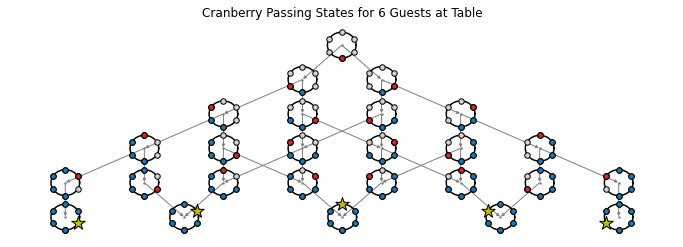

In [15]:
# plot the adjacency graph
fig, ax = plt.subplots(figsize=(12, 4))
plt.title("Cranberry Passing States for {} Guests at Table".format(n_guests))
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True, arrowsize=6, font_size=10, node_size=2, node_color='grey', edge_color='grey')

for state, state_label in zip(states, state_labels):
    p = pos[state_label]
    plot_state(state, n_guests, p=p, r = 27, s=30, ax=ax)

Text(0.5, 0, 'Guest Number (k)')

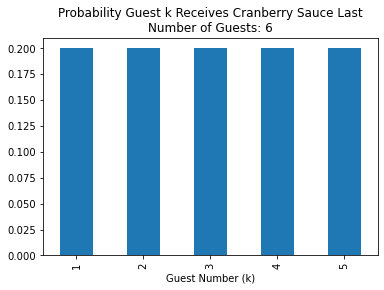

In [16]:
p_last = receive_cranberries_last_probabilities(n_guests)
fig, ax = plt.subplots(facecolor='w')
p_last.plot.bar(ax=ax)
ax.get_legend().remove()
ax.set_title('Probability Guest k Receives Cranberry Sauce Last\nNumber of Guests: {}'.format(n_guests))
ax.set_xlabel('Guest Number (k)')

## Twenty Guests

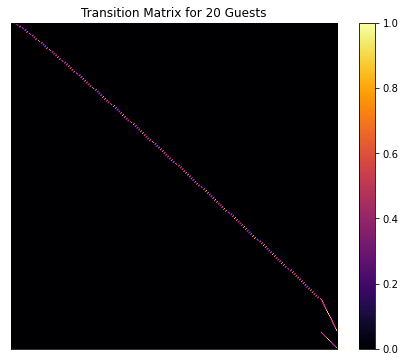

In [17]:
n_guests = 20
states, state_to_idx, n_states = generate_states(n_guests)
state_labels = [str(s) for s in states]
P = cranberry_passing_transition_matrix(n_guests)

# construct the plot
fig, ax = plt.subplots(figsize = (8,6), facecolor = 'w')
cm = ax.imshow(P,  cmap='inferno')

# major ticks with labels
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("Transition Matrix for {} Guests".format(n_guests))
fig.colorbar(cm);

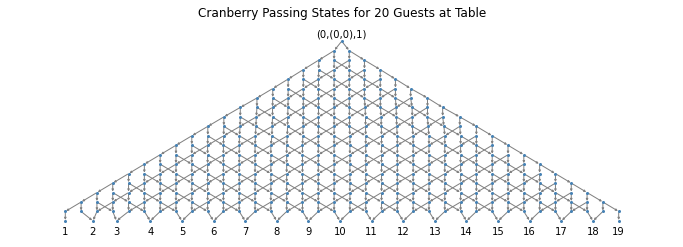

In [18]:
# adjacency matrix is the matrix whose i,j is 1 if there is a transition from i to j
# and 0 otherwise
P_adjacency = P > 0

# construct the adjacency graph (for this problem, it's a directed tree) 
# from the adjacency matrix
G = nx.from_numpy_matrix(P_adjacency, create_using=nx.DiGraph)
only_label_terminal = [str(s) if type(s) == int else ('(0,(0,0),1)' if s == (0, (0,0), 1) else ' ') for s in states]
labels = dict(zip(range(len(G.nodes())), only_label_terminal))

# plot the adjacency graph
fig, ax = plt.subplots(figsize=(12, 4))
plt.title("Cranberry Passing States for {} Guests at Table".format(n_guests))
pos=graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True, font_size=10, node_size=4, arrowsize=4,
        node_color='steelblue', edge_color='grey')

# manually offset the label positions
for k in labels.keys():
    tmp = np.array(pos[k])    
    if labels[k] == '(0,(0,0),1)':        
        tmp += np.array([0, 60])
        pos[k] = tmp
    else:
        tmp += np.array([0, -75])
        pos[k] = tmp
nx.draw_networkx_labels(G,pos,labels,font_size=10,font_color='k');

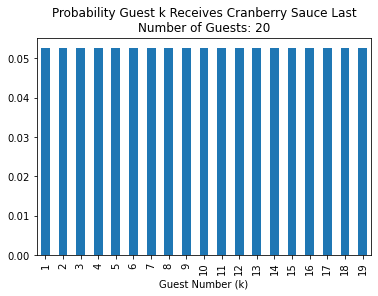

In [19]:
p_last = receive_cranberries_last_probabilities(n_guests)
fig, ax = plt.subplots(facecolor='w')
p_last.plot.bar(ax=ax)
ax.set_title('Probability Guest k Receives Cranberry Sauce Last\nNumber of Guests: {}'.format(n_guests))
ax.set_xlabel('Guest Number (k)')
ax.get_legend().remove()

## Compute Last Probability and Mean Passes For $n_{guests} = 3,4,...,20$

In [20]:
import time

# code isn't set up to run n = 2 since it's trivial
df_p_and_means_all = pd.DataFrame(
    [(2, 1, 1, 1)], 
    columns = ['n_guests', 'guest_number', 
                'probability_last', 'mean_number_passes']
)

# range to compute
n_guests_lo = 3
n_guests_hi = 20

for n_guests in range(n_guests_lo, n_guests_hi + 1):
    tic = time.time()
    df_p_last = receive_cranberries_last_probabilities(n_guests)
    df_mean_last = mean_passes(n_guests)
    toc = time.time()
    print("Completed Calculation for n_guests = {} in {:0.03f} seconds".format(n_guests, toc - tic))
    
    # Create a temporary dataframe for current step's results
    df_tmp = pd.merge(df_p_last, df_mean_last, left_index=True, right_index=True)
    df_tmp['n_guests'] = n_guests
    df_tmp = df_tmp.reset_index()
    
    # Concatenate curent step's results on final dataframe
    df_p_and_means_all = pd.concat([df_p_and_means_all, df_tmp])
        
df_p_and_means_all = df_p_and_means_all.reset_index(drop=True)

Completed Calculation for n_guests = 3 in 0.003 seconds
Completed Calculation for n_guests = 4 in 0.002 seconds
Completed Calculation for n_guests = 5 in 0.003 seconds
Completed Calculation for n_guests = 6 in 0.004 seconds
Completed Calculation for n_guests = 7 in 0.004 seconds
Completed Calculation for n_guests = 8 in 0.006 seconds
Completed Calculation for n_guests = 9 in 0.011 seconds
Completed Calculation for n_guests = 10 in 0.020 seconds
Completed Calculation for n_guests = 11 in 0.041 seconds
Completed Calculation for n_guests = 12 in 0.082 seconds
Completed Calculation for n_guests = 13 in 0.185 seconds
Completed Calculation for n_guests = 14 in 0.393 seconds
Completed Calculation for n_guests = 15 in 0.815 seconds
Completed Calculation for n_guests = 16 in 1.745 seconds
Completed Calculation for n_guests = 17 in 3.759 seconds
Completed Calculation for n_guests = 18 in 7.677 seconds
Completed Calculation for n_guests = 19 in 17.270 seconds
Completed Calculation for n_guests = 

In [21]:
df_p_and_means_all.to_csv("./output/analytical_prob_and_mean_passes_last.csv", index=False)

In [22]:
# create dataframe for mean number of passes - without conditioning
df_tmp = df_p_and_means_all.copy()

# temporary column for computing unconditional expectation
df_tmp['TMP'] = df_tmp['probability_last'] * df_tmp['mean_number_passes']
df_mean_passes = df_tmp.groupby('n_guests')[['TMP']].sum()['TMP'].reset_index()
df_mean_passes = df_mean_passes.rename(columns = {'TMP' : 'mean_number_passes'})
df_mean_passes['inefficiency'] = (
    df_mean_passes['mean_number_passes'] / (df_mean_passes['n_guests'] - 1) - 1
)

# export to file
df_mean_passes.to_csv('./output/analytical_mean_passes_and_inefficency.csv', index=False)

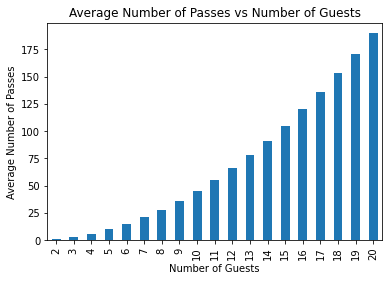

In [23]:
# plot unconditional mean passes
fig, ax = plt.subplots(facecolor='w')
df_mean_passes.plot.bar(x = 'n_guests', y='mean_number_passes', ax=ax)
ax.set_title('Average Number of Passes vs Number of Guests')
ax.set_xlabel('Number of Guests')
ax.set_ylabel('Average Number of Passes')
ax.get_legend().remove()

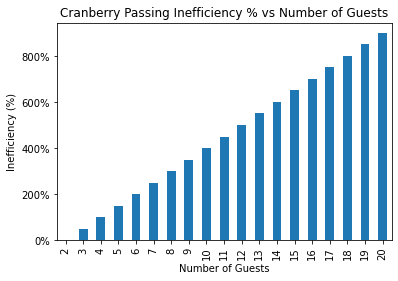

In [24]:
# plot inefficiency %
fig, ax = plt.subplots(facecolor='w')
df_mean_passes.plot.bar(x = 'n_guests', y = 'inefficiency', ax=ax)
ax.set_title("Cranberry Passing Inefficiency % vs Number of Guests")
ax.set_xlabel("Number of Guests")
ax.set_ylabel("Inefficiency (%)")
vals = ax.get_yticks()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()

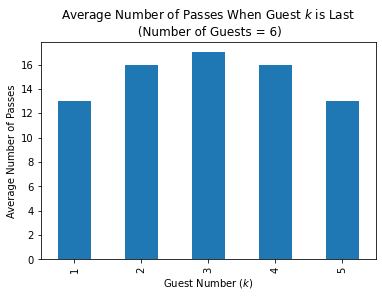

In [25]:
# Plot conditional mean number of passes when n_guests = 6
fig, ax = plt.subplots(facecolor='w')
df_p_and_means = df_p_and_means_all[df_p_and_means_all['n_guests'] == 6]
df_p_and_means.plot.bar(x = 'guest_number', y = 'mean_number_passes', ax =ax)

ax.set_title("Average Number of Passes When Guest $k$ is Last\n (Number of Guests = 6)")
ax.set_xlabel("Guest Number $(k)$")
ax.set_ylabel("Average Number of Passes")
ax.get_legend().remove()

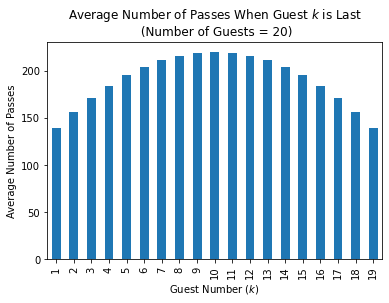

In [26]:
# Plot conditional mean number of passes when n_guests = 20
fig, ax = plt.subplots(facecolor='w')
df_p_and_means = df_p_and_means_all[df_p_and_means_all['n_guests'] == 20]
df_p_and_means.plot.bar(x = 'guest_number', y = 'mean_number_passes', ax =ax)

ax.set_title("Average Number of Passes When Guest $k$ is Last\n (Number of Guests = 20)")
ax.set_xlabel("Guest Number $(k)$")
ax.set_ylabel("Average Number of Passes")
ax.get_legend().remove()